# ML Problem: 

## Libraries & Data Loading

In [1]:
import pandas as pd
import numpy as np

In [2]:
# data loading
df = pd.read_csv('human_trafficking.csv')
df.head()

/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_85520/3103596529.py:2: DtypeWarning: Columns (54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('human_trafficking.csv')


,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,meansOfControlDebtBondage,meansOfControlTakesEarnings,...,typeOfSexPrivateSexualServices,typeOfSexConcatenated,isAbduction,RecruiterRelationship,CountryOfExploitation,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown
0,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
1,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
2,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
3,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1
4,2002,Case Management,Female,18--20,Adult,-99,-99,CO,-99,-99,...,-99,-99,-99,-99,-99,0,0,0,0,1


In [3]:
# -99 are considered mising values (NaN), so we convert them for easier handling
df.replace('-99', np.nan, inplace=True)
df.replace(-99, np.nan, inplace=True)

## EDA

In [4]:
df.shape

(48801, 63)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48801 entries, 0 to 48800
Data columns (total 63 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   yearOfRegistration                      48801 non-null  int64  
 1   Datasource                              48801 non-null  object 
 2   gender                                  48801 non-null  object 
 3   ageBroad                                36439 non-null  object 
 4   majorityStatus                          36439 non-null  object 
 5   majorityStatusAtExploit                 9290 non-null   object 
 6   majorityEntry                           6491 non-null   object 
 7   citizenship                             48523 non-null  object 
 8   meansOfControlDebtBondage               2496 non-null   float64
 9   meansOfControlTakesEarnings             3997 non-null   float64
 10  meansOfControlRestrictsFinancialAccess  253 non-null    fl

In [6]:
df.isnull().sum()

yearOfRegistration                      0
Datasource                              0
gender                                  0
ageBroad                            12362
majorityStatus                      12362
                                    ...  
recruiterRelationIntimatePartner     8807
recruiterRelationFriend              8807
recruiterRelationFamily              8807
recruiterRelationOther               8807
recruiterRelationUnknown               77
Length: 63, dtype: int64

In [7]:
df['citizenship'].unique()

array(['CO', 'MD', 'RO', 'UA', 'BY', 'GH', 'AL', 'BG', 'UZ', 'ID', 'TJ',
       'CD', 'ML', 'GW', 'CI', 'SN', 'SL', 'KG', 'GN', 'KH', 'LA', 'KZ',
       'TM', 'BF', 'NE', 'HT', 'LK', 'BO', 'MM', 'AF', 'UG', 'ER', 'NG',
       'NP', 'PH', 'BD', '00', 'US', nan, 'TH', 'KR', 'VN', 'KE', 'CN',
       'MX', 'MG'], dtype=object)

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go

# Optional: Set plotting style
sns.set(style="whitegrid")


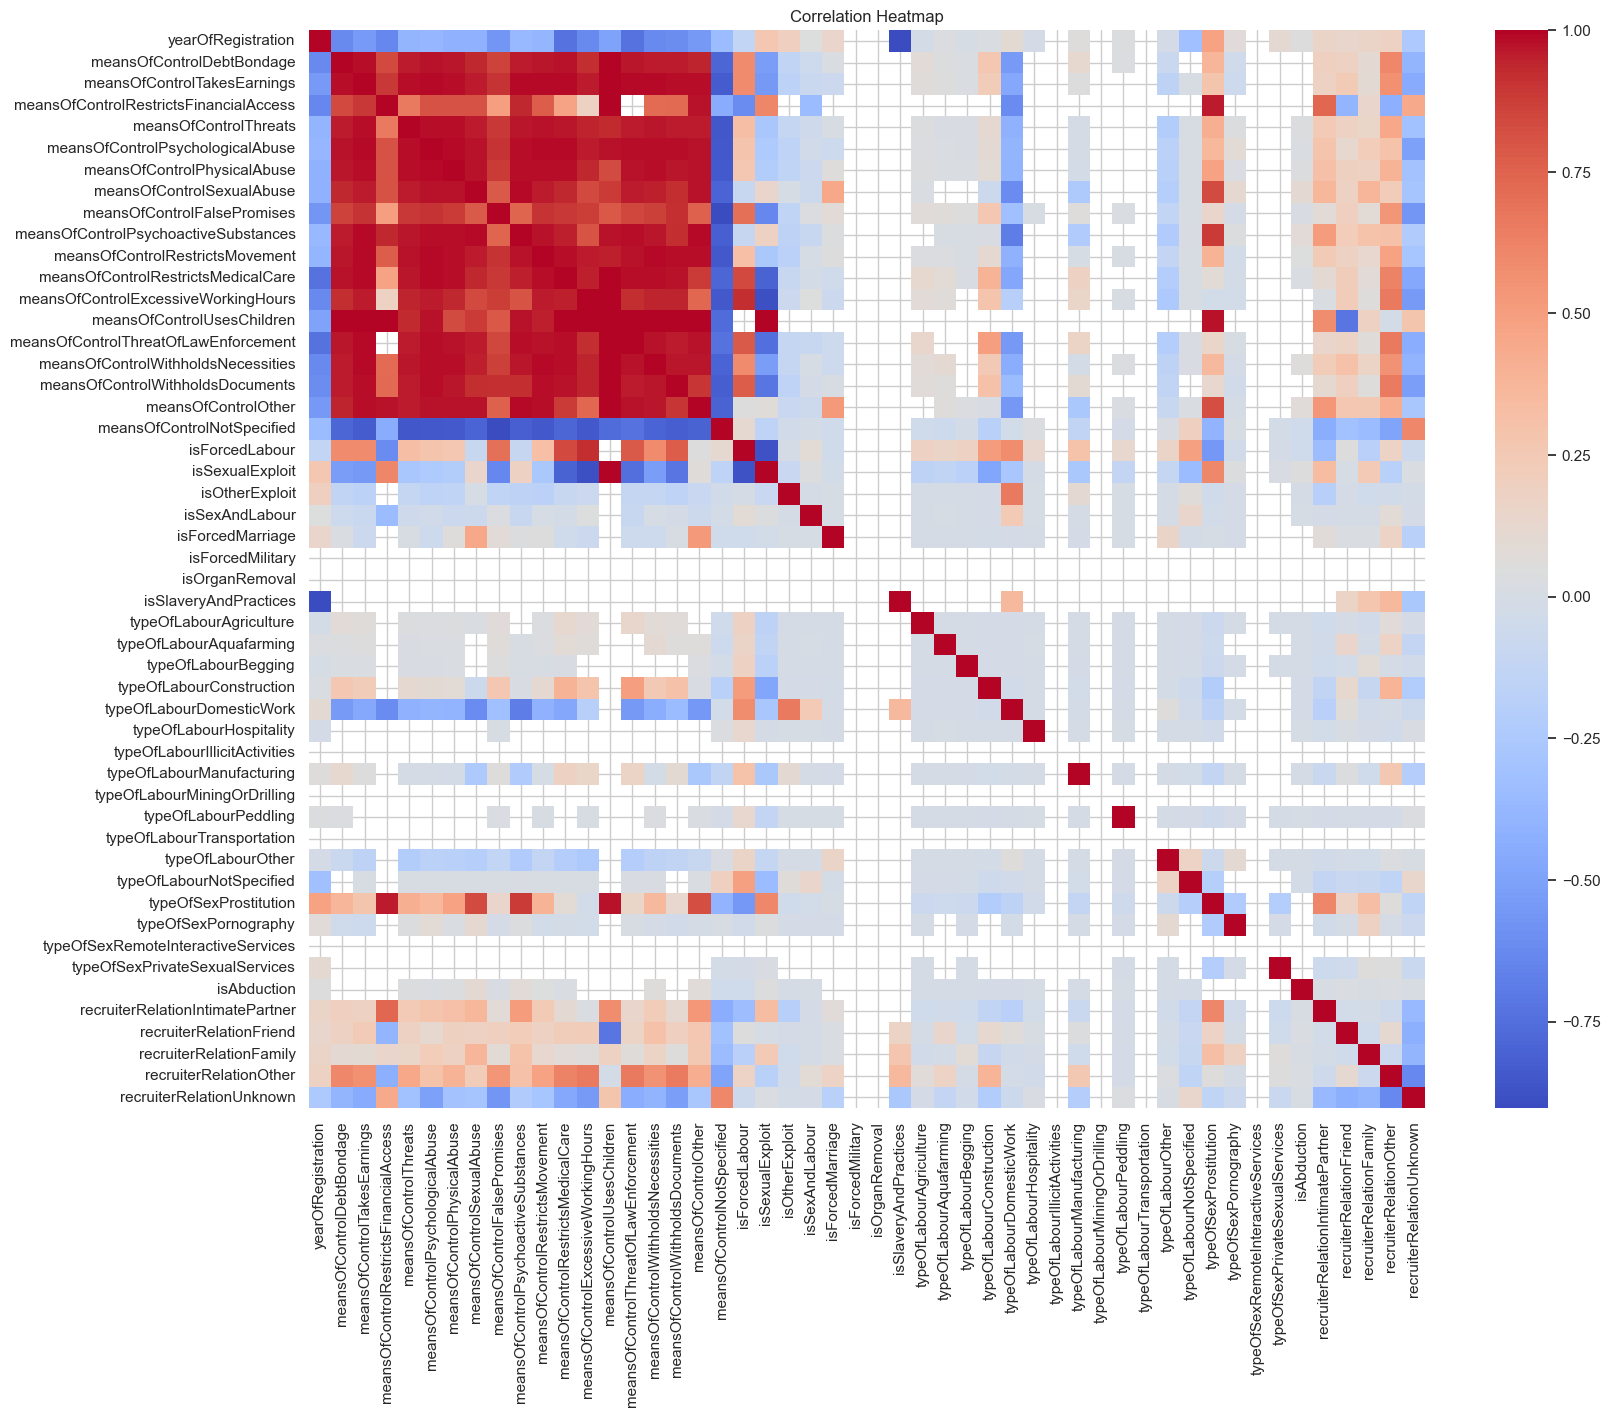

In [9]:
plt.figure(figsize=(18, 14))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()


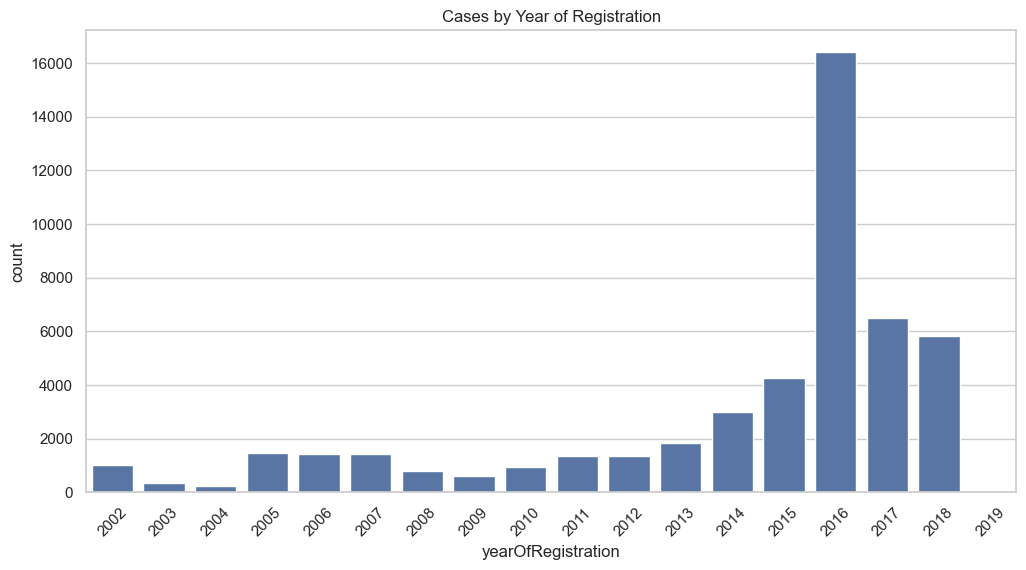

In [10]:
plt.figure(figsize=(12, 6))
sns.countplot(x='yearOfRegistration', data=df, order=sorted(df['yearOfRegistration'].dropna().unique()))
plt.xticks(rotation=45)
plt.title("Cases by Year of Registration")
plt.show()


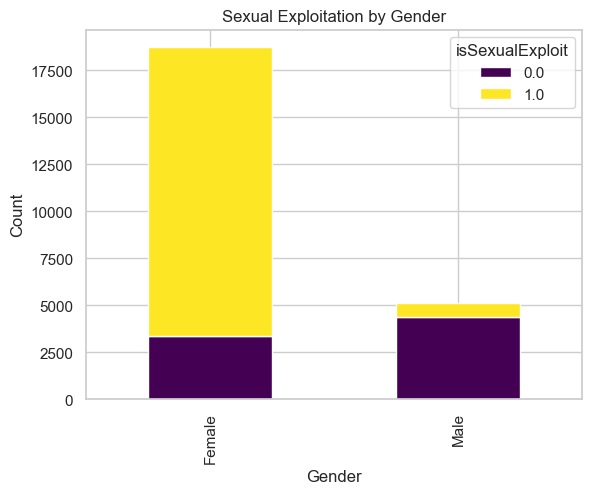

In [11]:
cross_tab = pd.crosstab(df['gender'], df['isSexualExploit'])
cross_tab.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Sexual Exploitation by Gender")
plt.ylabel("Count")
plt.xlabel("Gender")
plt.legend(title='isSexualExploit')
plt.show()


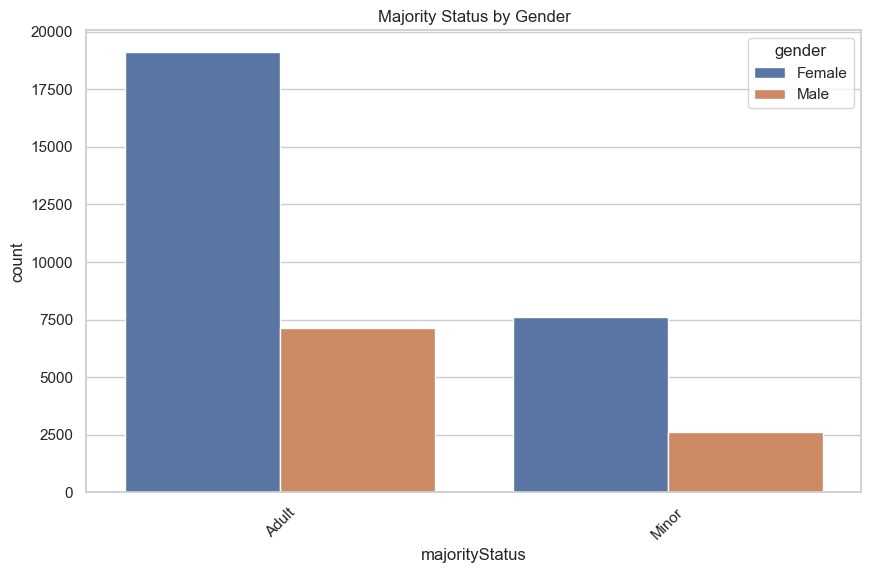

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='majorityStatus', hue='gender')
plt.title("Majority Status by Gender")
plt.xticks(rotation=45)
plt.show()


In [13]:
%pip install pycountry


Note: you may need to restart the kernel to use updated packages.


In [14]:
import pycountry
import pandas as pd
import plotly.express as px

# Create a mapping from ISO alpha-2 codes to full country names
def code_to_country(code):
    try:
        if pd.isna(code) or code == '00':
            return 'Unknown'
        return pycountry.countries.get(alpha_2=code).name
    except:
        return 'Unknown'

# Apply the mapping
df['citizenship_country'] = df['citizenship'].apply(code_to_country)

# Count occurrences
country_counts = df['citizenship_country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

# Plot the choropleth map
fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Cases by Citizenship Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [15]:
country_counts = df['CountryOfExploitation'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

fig = px.choropleth(country_counts,
                    locations="country",
                    locationmode="country names",
                    color="count",
                    title="Exploitation Cases by Country",
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()


In [16]:
subset = df[['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']].dropna().copy()
subset = subset[subset['typeOfExploitConcatenated'] != '']

subset = subset.groupby(['gender', 'typeOfExploitConcatenated', 'CountryOfExploitation']).size().reset_index(name='count')

# Create node list
all_nodes = pd.concat([
    subset['gender'],
    subset['typeOfExploitConcatenated'],
    subset['CountryOfExploitation']
]).unique().tolist()

# Map node labels to index
label_to_idx = {label: idx for idx, label in enumerate(all_nodes)}

# Create links
source = subset['gender'].map(label_to_idx)
target = subset['typeOfExploitConcatenated'].map(label_to_idx)
middle_target = subset['CountryOfExploitation'].map(label_to_idx)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=all_nodes
    ),
    link=dict(
        source=source,
        target=target,
        value=subset['count']
    )
)])

fig.update_layout(title_text="Sankey Diagram: Gender → Type of Exploitation", font_size=10)
fig.show()


/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_85520/2766445616.py:26: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_85520/2766445616.py:26: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_85520/2766445616.py:26: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_85520/2766445616.py:26: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.

/var/folders/zk/vd14bsbx2679v9y9w2drl53c0000gn/T/ipykernel_85520/2766445616.py:26: UserWarning:

Tight layout not applied. tight_layout cannot make Axes hei

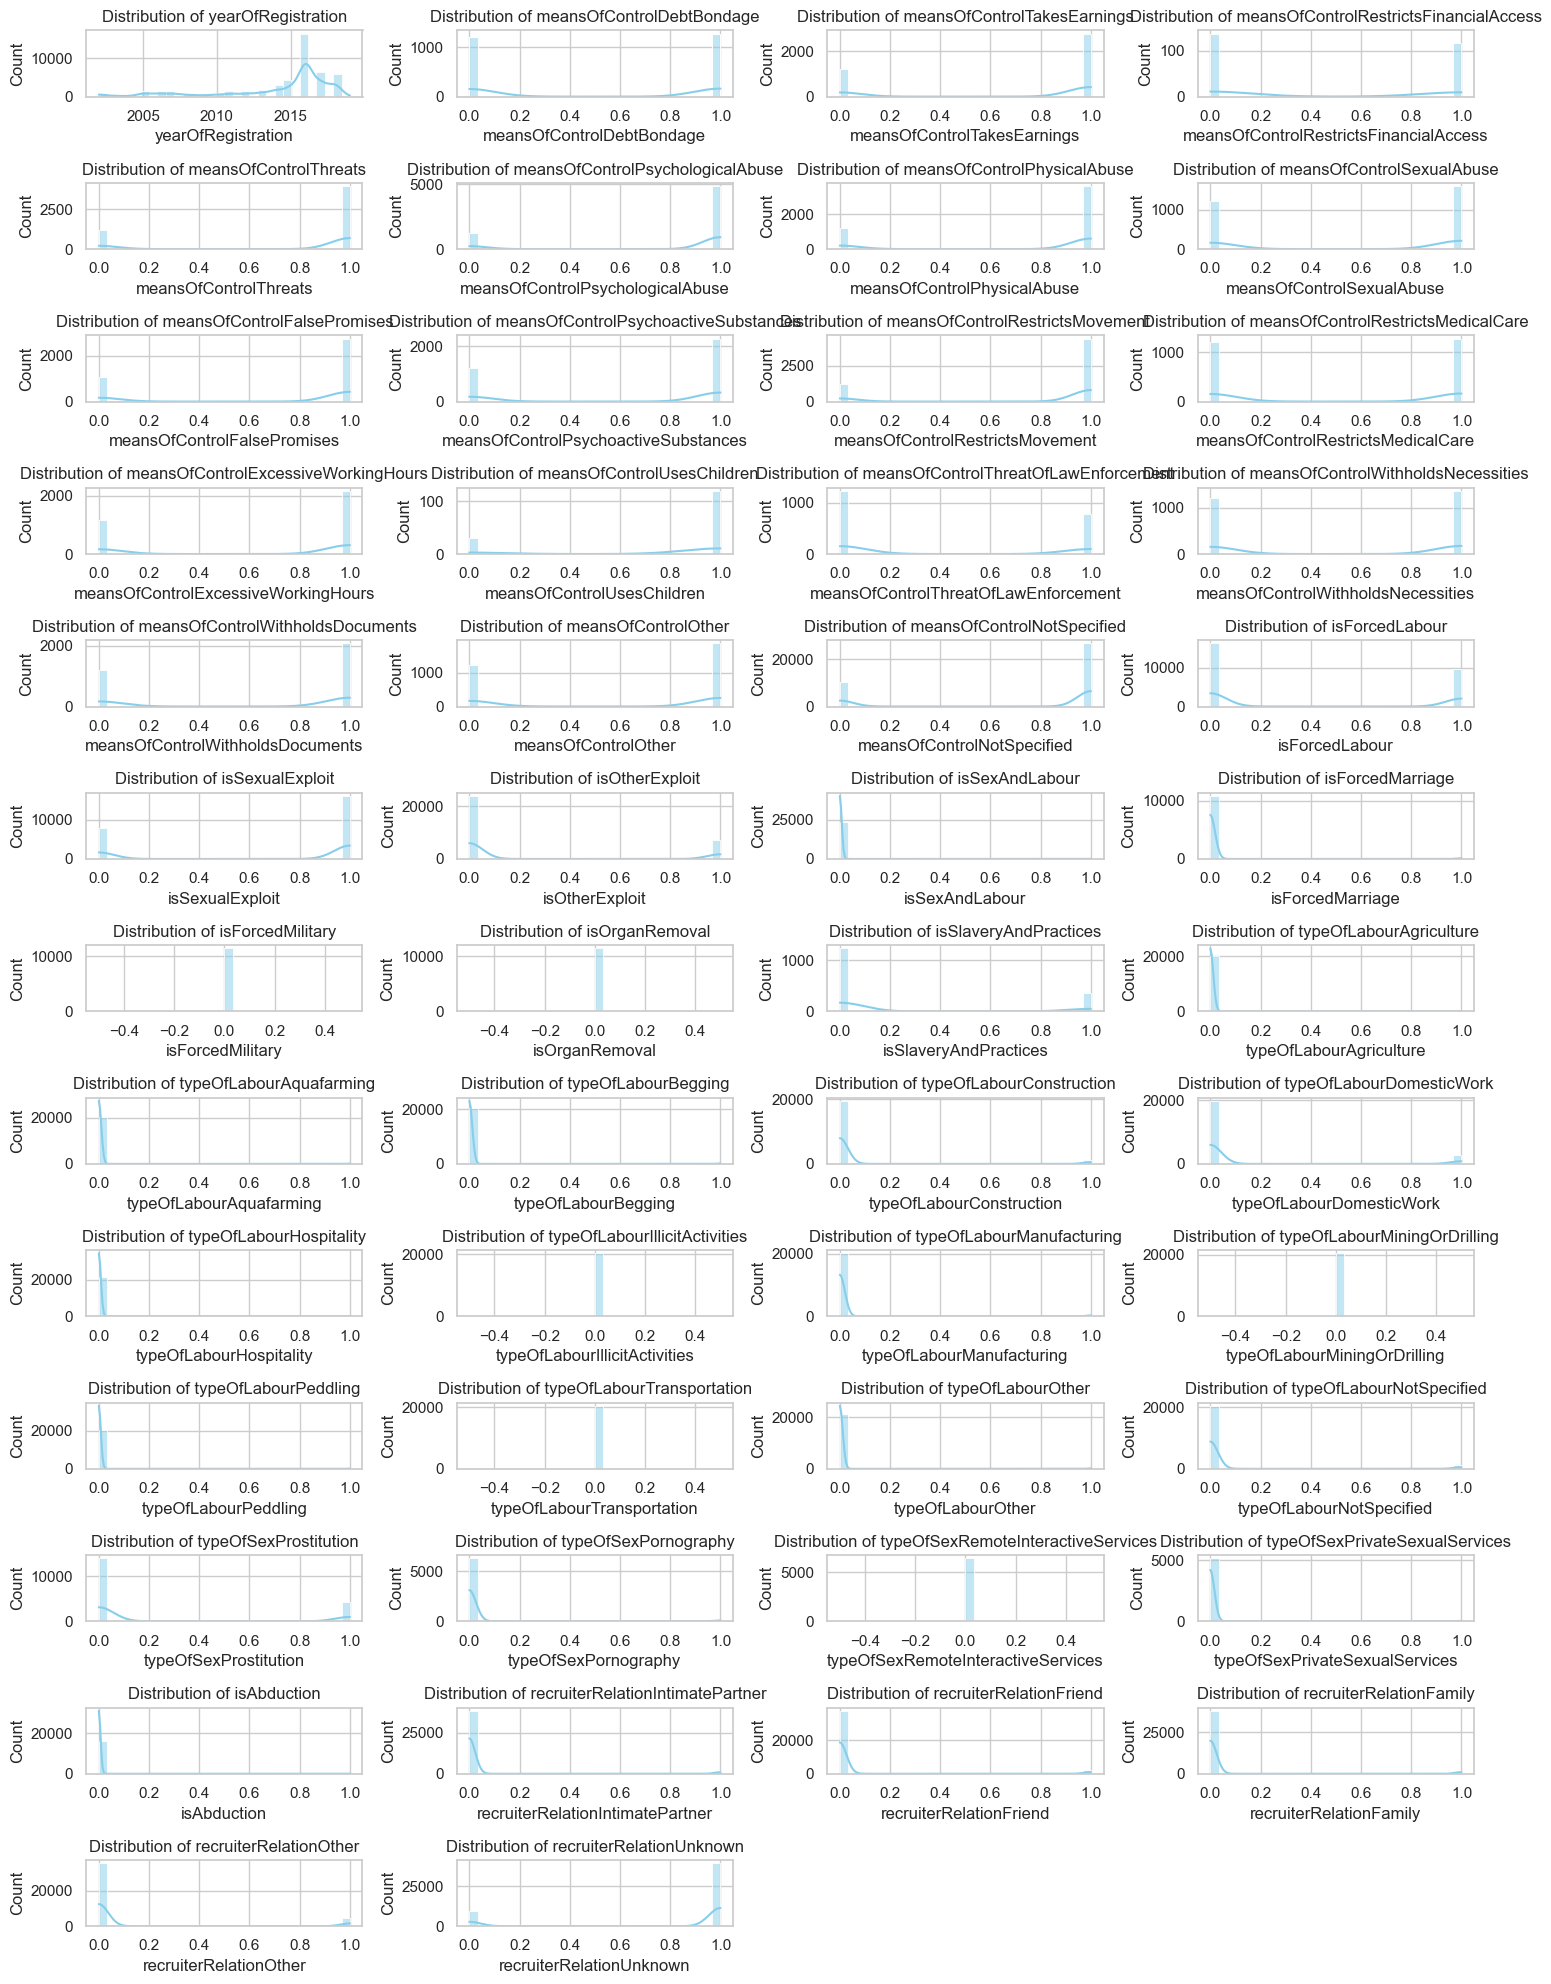

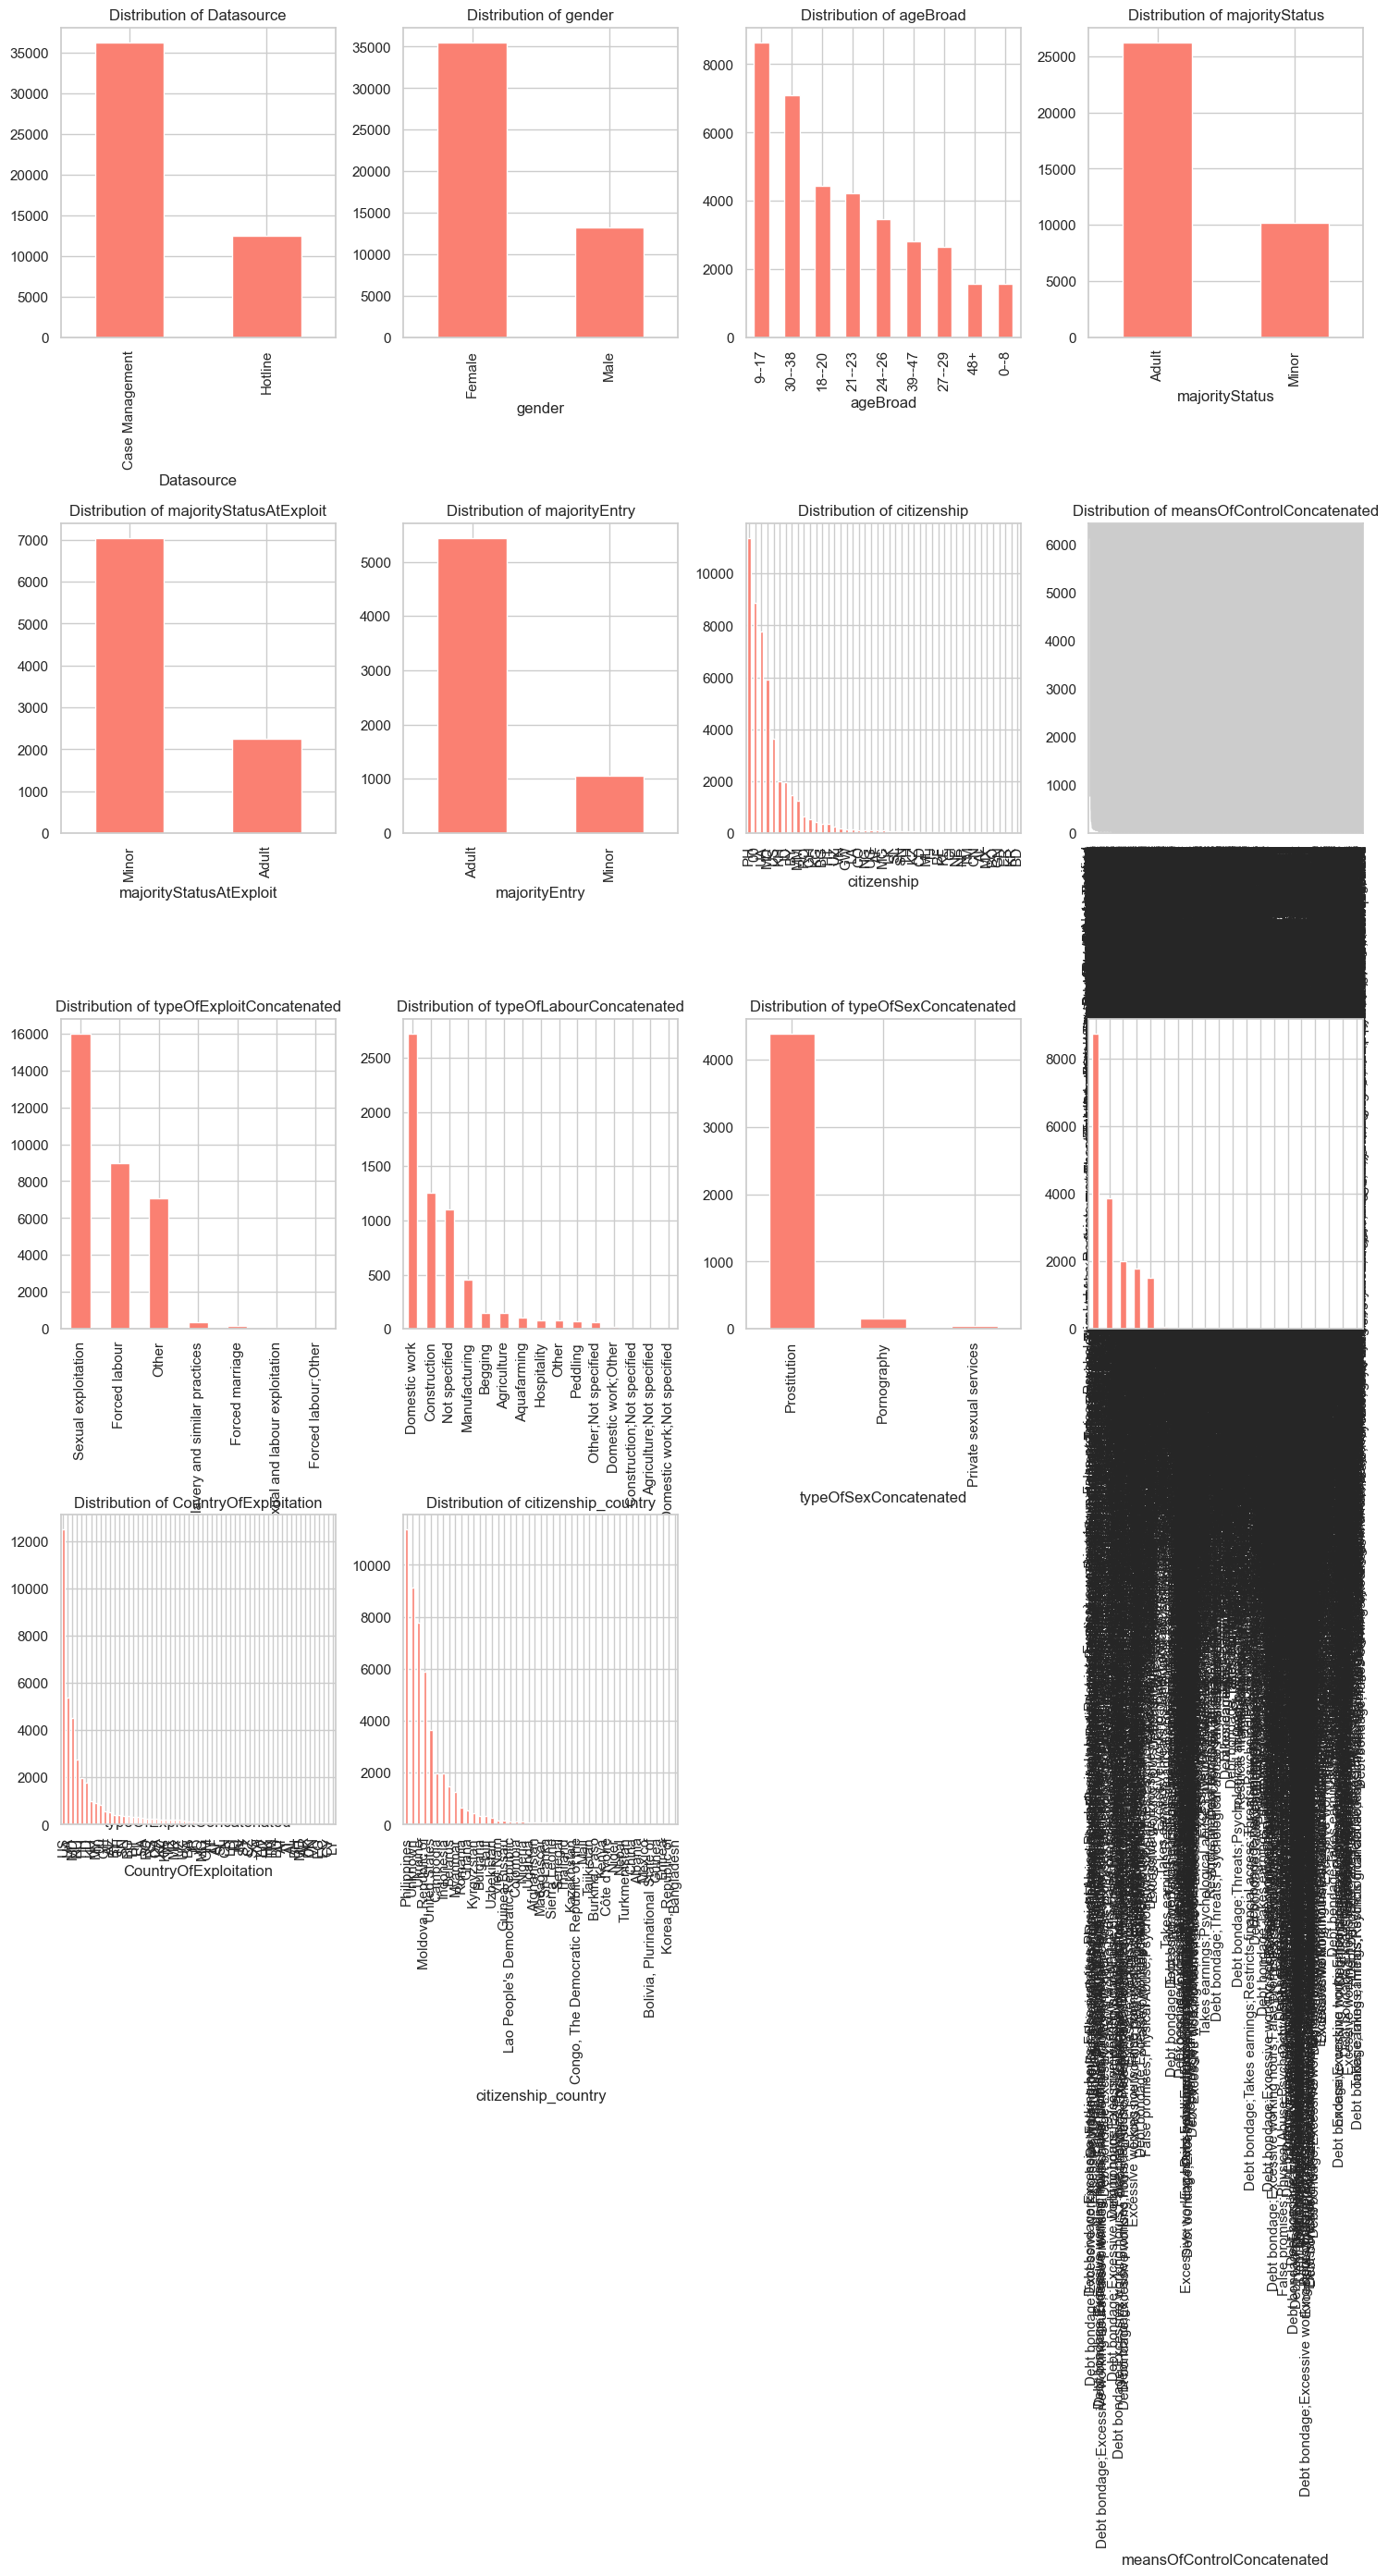

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a grid of subplots to accommodate all features
num_columns = df.select_dtypes(include=['float64', 'int64']).columns
cat_columns = df.select_dtypes(include=['object']).columns

# Set up the plot for numerical features
plt.figure(figsize=(15, 20))

# Plot distributions for numeric features
for i, column in enumerate(num_columns):
    plt.subplot(len(num_columns) // 4 + 1, 4, i+1)
    sns.histplot(df[column].dropna(), kde=True, bins=30, color="skyblue")
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

# Set up the plot for categorical features
plt.figure(figsize=(15, 20))

# Plot distributions for categorical features
for i, column in enumerate(cat_columns):
    plt.subplot(len(cat_columns) // 4 + 1, 4, i+1)
    df[column].value_counts().plot(kind='bar', color="salmon")
    plt.title(f'Distribution of {column}')
    plt.tight_layout()

plt.show()


bro this is crazy, i cannot understand anything lol

In [18]:
import plotly.express as px
import pandas as pd

# Clean up ageBroad formatting
df['ageBroad'] = df['ageBroad'].str.replace('--', '-', regex=False)

# Add victim count column
df['Victims'] = 1

# Filter out missing values
filtered_df = df[df['ageBroad'].notna()]

# Group and count
grouped = filtered_df.groupby(['gender', 'ageBroad'])['Victims'].sum().reset_index()

# Define proper order of age groups
age_order = ['0-8', '9-17', '18-20', '21-23', '24-26', '27-29', '30-38', '39-47', '48-56', '57+']
grouped['ageBroad'] = pd.Categorical(grouped['ageBroad'], categories=age_order, ordered=True)
grouped = grouped.sort_values(['ageBroad'])

# Plot
fig = px.bar(
    grouped,
    x='ageBroad',
    y='Victims',
    color='gender',
    barmode='group',
    title='Human Trafficking Victims by Age Group and Gender',
    labels={'Victims': 'Number of Victims', 'ageBroad': 'Age Group'}
)

fig.update_layout(width=800, height=500)
fig.show()


females are more likely to be human trafficked than males. the highest number of victims are in the age range of 30-38 where we can assume it's because of manual work labour, while females highest victims range between 9-17 which could be bc of sexual exploitation. proof of the assumption

# Feature engineering

# Model selection

# Model validation

# Conclusion